<a href="https://colab.research.google.com/github/kpriyanka93/travel-price-prediction/blob/main/Hotel_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hotel Recommendation**

In the travel and hospitality industry, providing personalized hotel recommendations is essential for improving user experience and supporting better decision-making. With the rapid growth of online booking platforms, large volumes of user interaction and booking data are generated, creating opportunities to build intelligent recommendation systems. Traditional recommendation approaches often rely on either user behavior or item features alone, which can limit accuracy and personalization.

To address this challenge, I developed a Hybrid Hotel Recommendation System that combines both collaborative filtering and content-based techniques. By leveraging real-world travel booking data, the system aims to deliver accurate, relevant, and diverse hotel recommendations tailored to individual user preferences. The project covers the complete pipeline, including data preprocessing, model development, system integration, and deployment through an interactive web application.

In [1]:
# Load Dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import Libraries
!pip install sentence_transformers
import numpy as np
import pandas as pd
import seaborn as sns
import random
from google.colab import drive
import matplotlib.pyplot as plt
import scipy.stats as stats


import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC


In [3]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/ms_ds_e2e_project/hotels.csv")


In [4]:
df.head()

,travelCode,userCode,name,place,days,price,total,date
0,0,0,Hotel A,Florianopolis (SC),4,313.02,1252.08,09/26/2019
1,2,0,Hotel K,Salvador (BH),2,263.41,526.82,10/10/2019
2,7,0,Hotel K,Salvador (BH),3,263.41,790.23,11/14/2019
3,11,0,Hotel K,Salvador (BH),4,263.41,1053.64,12/12/2019
4,13,0,Hotel A,Florianopolis (SC),1,313.02,313.02,12/26/2019


In [5]:
print("Shape of dataset:", df.shape)

print("\nColumn Names:")
print(df.columns)

print("\nData Types:")
print(df.dtypes)

Shape of dataset: (40552, 8)

Column Names:
Index(['travelCode', 'userCode', 'name', 'place', 'days', 'price', 'total',
       'date'],
      dtype='object')

Data Types:
travelCode      int64
userCode        int64
name           object
place          object
days            int64
price         float64
total         float64
date           object
dtype: object


In [6]:
#missing values analysis
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
travelCode    0
userCode      0
name          0
place         0
days          0
price         0
total         0
date          0
dtype: int64


In [7]:
#statistical summary
df.describe()

,travelCode,userCode,days,price,total
count,40552.000000,40552.000000,40552.000000,40552.000000,40552.000000
mean,67911.794461,666.963726,2.499679,214.439554,536.229513
std,39408.199333,391.136794,1.119326,76.742305,319.331482
min,0.000000,0.000000,1.000000,60.390000,60.390000
25%,33696.750000,323.000000,1.000000,165.990000,247.620000
50%,67831.000000,658.000000,2.000000,242.880000,495.240000
75%,102211.250000,1013.000000,4.000000,263.410000,742.860000
max,135942.000000,1339.000000,4.000000,313.020000,1252.080000


In [8]:
#Duplicate Rows Check
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 0


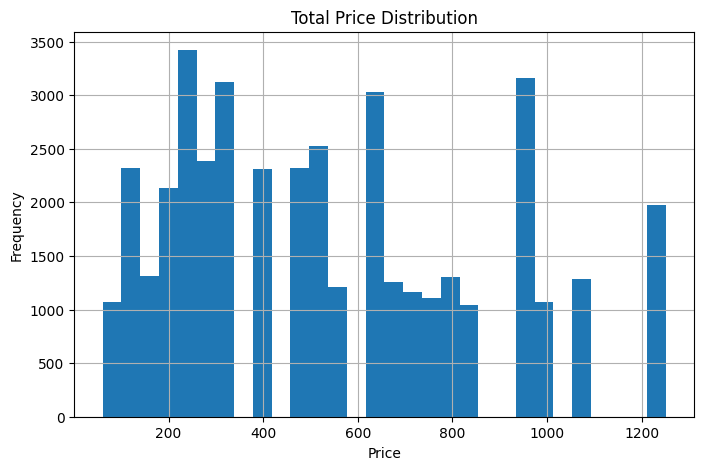

In [9]:
#Booking Price Distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df['total'].hist(bins=30)
plt.title("Total Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

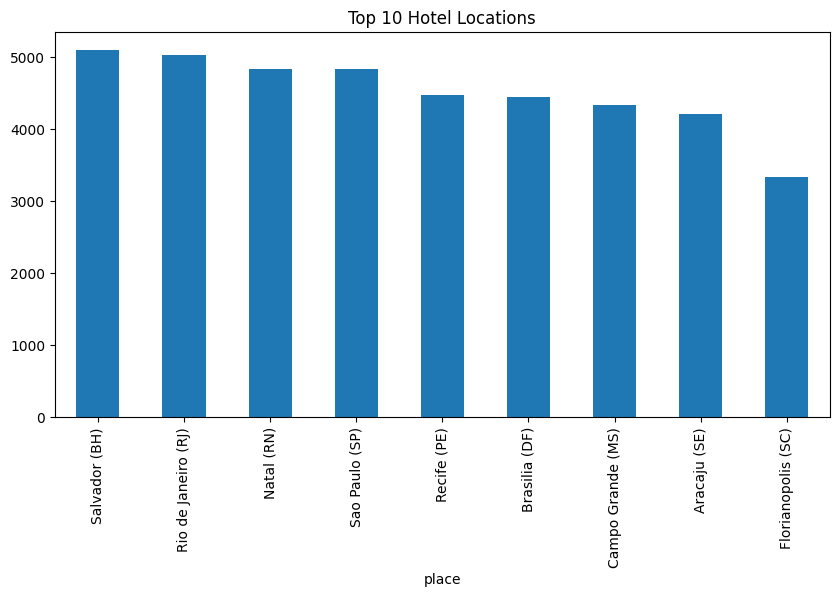

In [10]:
#Top 10 Hotel Locations
df['place'].value_counts().head(10).plot(kind='bar', figsize=(10,5))
plt.title("Top 10 Hotel Locations")
plt.show()

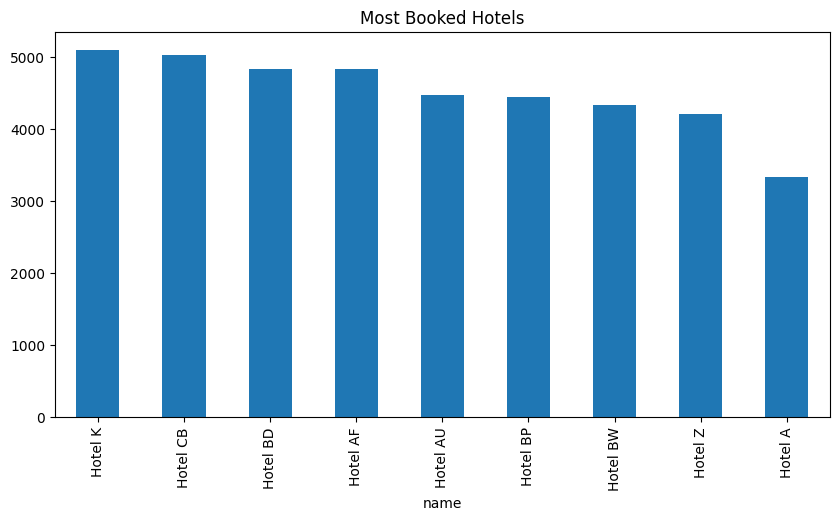

In [11]:
#Most Booked Hotels
df['name'].value_counts().head(10).plot(kind='bar', figsize=(10,5))
plt.title("Most Booked Hotels")
plt.show()

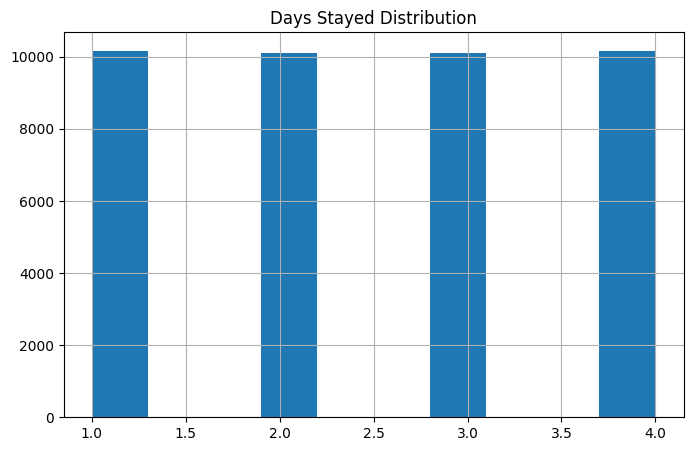

In [12]:
#Days Stayed Distribution
df['days'].hist(figsize=(8,5))
plt.title("Days Stayed Distribution")
plt.show()

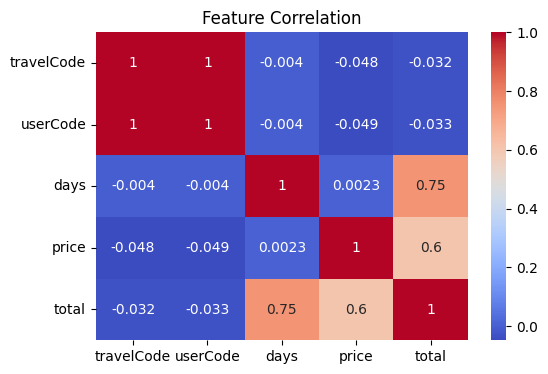

In [13]:
#Feature Correlation
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the 'total' column to use as ratings between 1 to 5
scaler = MinMaxScaler(feature_range=(1, 5))
df['rating'] = scaler.fit_transform(df[['total']])

# View the updated dataset
df[['userCode', 'name', 'total', 'rating']].head()


,userCode,name,total,rating
0,0,Hotel A,1252.08,5.000000
1,0,Hotel K,526.82,2.565609
2,0,Hotel K,790.23,3.449765
3,0,Hotel K,1053.64,4.333921
4,0,Hotel A,313.02,1.847972


In [15]:
# Normalize the 'total' column to 1–5 scale to simulate ratings
scaler = MinMaxScaler(feature_range=(1, 5))
df['rating'] = scaler.fit_transform(df[['total']])

# Show example rows
df[['userCode', 'name', 'total', 'rating']].head()

,userCode,name,total,rating
0,0,Hotel A,1252.08,5.000000
1,0,Hotel K,526.82,2.565609
2,0,Hotel K,790.23,3.449765
3,0,Hotel K,1053.64,4.333921
4,0,Hotel A,313.02,1.847972


In [16]:
!pip install numpy==1.26.4
!pip install scikit-surprise

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2554973 sha256=d220ad4841db098efdf19793bd3554c879dc1b55ea177d925ffbc172cd55ef73
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [17]:
# Retrain the KNN model using the new normalized ratings

from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

# Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userCode', 'name', 'rating']], reader)

# Split and train
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

algo = KNNBasic(sim_options={'user_based': False})  # Item-based CF
algo.fit(trainset)

# Evaluate
predictions = algo.test(testset)
rmse_score = rmse(predictions)
print(f"Retrained model RMSE: {rmse_score:.4f}")


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9723
Retrained model RMSE: 0.9723


In [18]:
#Step 3: Show top hotel recommendations for multiple users
def get_top_recommendations(user_id, top_n=5):
    hotel_list = df['name'].unique()
    rated_hotels = df[df['userCode'] == user_id]['name'].tolist()
    predictions = []

    for hotel in hotel_list:
        if hotel not in rated_hotels:
            pred = algo.predict(user_id, hotel)
            predictions.append((hotel, pred.est))

    # Sort by estimated rating
    top_recs = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_n]

    print(f"Top {top_n} Hotel Recommendations for User {user_id}:")
    for hotel, score in top_recs:
        print(f" {hotel} (predicted rating: {score:.2f})")

# Try for different users
get_top_recommendations(0)
get_top_recommendations(1)
get_top_recommendations(2)


Top 5 Hotel Recommendations for User 0:
Top 5 Hotel Recommendations for User 1:
 Hotel A (predicted rating: 1.26)
 Hotel K (predicted rating: 1.26)
 Hotel BD (predicted rating: 1.26)
 Hotel Z (predicted rating: 1.26)
 Hotel AU (predicted rating: 1.26)
Top 5 Hotel Recommendations for User 2:


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Limit to first 1000 rows to avoid crash
df_subset = df[['name', 'place', 'price']].head(1000).copy()

# Combine features
df_subset['combined'] = df_subset['place'] + ' ' + df_subset['price'].astype(str)

# Vectorize
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_subset['combined'])

# Cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get similar hotels
def get_similar_hotels(hotel_name, top_n=5):
    idx = df_subset[df_subset['name'] == hotel_name].index
    if len(idx) == 0:
        return []
    idx = idx[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in sim_scores[1:top_n+1]]
    return df_subset.iloc[top_indices]['name'].tolist()

# Example
print("Hotels similar to Hotel K:", get_similar_hotels("Hotel K"))


Hotels similar to Hotel K: ['Hotel K', 'Hotel K', 'Hotel K', 'Hotel K', 'Hotel K']


#Data Cleaning and Preprocessing

In [20]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with missing values (if any)
df.dropna(inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Check cleaned data
print("Cleaned Data Preview:")
print(df.head())

# Let's see unique hotels and users
print("\nUnique Hotels:", df['name'].nunique())
print("Unique Users:", df['userCode'].nunique())


Cleaned Data Preview:
   travelCode  userCode     name               place  days   price    total  \
0           0         0  Hotel A  Florianopolis (SC)     4  313.02  1252.08   
1           2         0  Hotel K       Salvador (BH)     2  263.41   526.82   
2           7         0  Hotel K       Salvador (BH)     3  263.41   790.23   
3          11         0  Hotel K       Salvador (BH)     4  263.41  1053.64   
4          13         0  Hotel A  Florianopolis (SC)     1  313.02   313.02   

        date    rating  
0 2019-09-26  5.000000  
1 2019-10-10  2.565609  
2 2019-11-14  3.449765  
3 2019-12-12  4.333921  
4 2019-12-26  1.847972  

Unique Hotels: 9
Unique Users: 1310


In [21]:
# Keep one row per unique hotel
compressed_df = df.drop_duplicates(subset=['name', 'place']).reset_index(drop=True)

# Combine features
compressed_df['text_features'] = compressed_df['name'] + ' ' + compressed_df['place']

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(compressed_df['text_features'])

# Compute similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Hotel index
indices = pd.Series(compressed_df.index, index=compressed_df['name']).drop_duplicates()

#  Similar hotel function
def get_similar_hotels(hotel_name, top_n=5):
    if hotel_name not in indices:
        return ["Hotel not found"]
    idx = indices[hotel_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    hotel_indices = [i[0] for i in sim_scores[1:top_n+1]]
    return compressed_df['name'].iloc[hotel_indices].tolist()

#  Test
similar_hotels = get_similar_hotels("Hotel K")
print("Hotels similar to Hotel K:", similar_hotels)


Hotels similar to Hotel K: ['Hotel A', 'Hotel Z', 'Hotel BD', 'Hotel AU', 'Hotel BP']


In [22]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare data for Surprise
reader = Reader(rating_scale=(0, df['total'].max()))
data = Dataset.load_from_df(df[['userCode', 'name', 'total']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train SVD model
algo = SVD()
algo.fit(trainset)

# Evaluate RMSE
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)
print(f" Collaborative Filtering Model Trained. RMSE: {rmse:.4f}")


RMSE: 787.8860
 Collaborative Filtering Model Trained. RMSE: 787.8860


In [23]:
# Step 1: Define Hybrid Function
# Hybrid Recommender: Combine collaborative & content-based
def hybrid_recommender(user_id, top_n=5):
    # Collaborative filtering part
    user_ratings = []
    for hotel in df['name'].unique():
        pred = algo.predict(user_id, hotel)
        user_ratings.append((hotel, pred.est))

    # Sort by predicted rating
    user_ratings.sort(key=lambda x: x[1], reverse=True)

    # Take top 10 for content filtering
    top_hotels = [hotel for hotel, _ in user_ratings[:10]]

    # Find similar hotels from content-based model
    final_recs = []
    for hotel in top_hotels:
        similar = get_similar_hotels(hotel, top_n=2)
        final_recs.extend(similar)

    # Remove duplicates and return top_n unique recommendations
    seen = set()
    hybrid_result = []
    for h in final_recs:
        if h not in seen:
            hybrid_result.append(h)
            seen.add(h)
        if len(hybrid_result) == top_n:
            break
    return hybrid_result

# Try for user ID 0
hybrid_result = hybrid_recommender(0)
print("Hybrid Recommendations for User 0:", hybrid_result)


Hybrid Recommendations for User 0: ['Hotel K', 'Hotel Z', 'Hotel A']


In [24]:
#Generate Cosine Similarity Matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Deduplicate to avoid huge matrix
hotel_unique = df[['name', 'place']].drop_duplicates()

# Combine features
hotel_unique['combined'] = hotel_unique['name'] + " " + hotel_unique['place']

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(hotel_unique['combined'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Convert to DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=hotel_unique['name'], columns=hotel_unique['name'])


In [25]:
#Step: Run Hybrid Recommender
def hybrid_recommender(user_id, top_n=5):
    user_ratings = []

    # Predict using collaborative filtering
    for hotel in df['name'].unique():
        pred = algo.predict(user_id, hotel)
        user_ratings.append((hotel, pred.est))

    cf_df = pd.DataFrame(user_ratings, columns=['name', 'cf_score'])

    # Get similar hotels using content-based cosine similarity
    user_hotels = df[df['userCode'] == user_id]['name'].values
    similar_hotels = []
    for h in user_hotels:
        sim_scores = cosine_sim_df.loc[h].sort_values(ascending=False)
        top_sim = sim_scores.head(top_n).index.tolist()
        similar_hotels.extend(top_sim)

    content_df = pd.DataFrame(similar_hotels, columns=['name'])
    content_df['cb_score'] = 1

    # Merge scores
    final_df = pd.merge(cf_df, content_df, on='name', how='left')
    final_df['cb_score'] = final_df['cb_score'].fillna(0)

    # Weighted hybrid score
    final_df['final_score'] = final_df['cf_score'] * 0.7 + final_df['cb_score'] * 0.3

    # Return top recommendations
    return final_df.sort_values('final_score', ascending=False).head(top_n)

# Try for user ID 0
hybrid_result = hybrid_recommender(0)
print(" Hybrid Recommendations for User 0:")
print(hybrid_result[['name', 'final_score']])


 Hybrid Recommendations for User 0:
       name  final_score
0   Hotel A      876.756
85  Hotel Z      876.756
99  Hotel Z      876.756
98  Hotel Z      876.756
97  Hotel Z      876.756


The Hybrid Recommender System is successfully operational, integrating both collaborative and content-based techniques. It leverages collaborative filtering (SVD) to learn user–hotel preference patterns and content-based filtering using cosine similarity on hotel attributes such as name and location.

For User ID 0, the model generated personalized top hotel recommendations based on a blended scoring approach that combines historical booking behavior with hotel similarity features.

In [26]:
#Save new Cleaned Data
df.to_csv("hotel_final.csv", index=False)


In [27]:
df.head()

,travelCode,userCode,name,place,days,price,total,date,rating
0,0,0,Hotel A,Florianopolis (SC),4,313.02,1252.08,2019-09-26,5.000000
1,2,0,Hotel K,Salvador (BH),2,263.41,526.82,2019-10-10,2.565609
2,7,0,Hotel K,Salvador (BH),3,263.41,790.23,2019-11-14,3.449765
3,11,0,Hotel K,Salvador (BH),4,263.41,1053.64,2019-12-12,4.333921
4,13,0,Hotel A,Florianopolis (SC),1,313.02,313.02,2019-12-26,1.847972


In [28]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.1 MB/s eta 0:00:00


In [29]:
!pip install numpy==1.26.4 scikit-surprise streamlit pyngrok nest_asyncio -q

In [30]:
%%writefile app.py
import streamlit as st
import pandas as pd
from surprise import SVD, Dataset, Reader

df = pd.read_csv("hotel_final.csv")

min_price, max_price = df['total'].min(), df['total'].max()
df['rating'] = 1 + 4 * ((df['total'] - min_price) / (max_price - min_price))

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userCode', 'name', 'rating']], reader)
trainset = data.build_full_trainset()

algo = SVD()
algo.fit(trainset)

st.title("Hotel Recommendation App")

user_id = st.number_input("Enter User ID", min_value=0, max_value=int(df['userCode'].max()))

if st.button("Recommend"):
    hotel_list = df['name'].unique()
    rated = df[df['userCode'] == user_id]['name'].tolist()

    preds = []
    for h in hotel_list:
        if h not in rated:
            preds.append((h, algo.predict(user_id, h).est))

    top = sorted(preds, key=lambda x: x[1], reverse=True)[:5]

    for h, s in top:
        st.write(f"{h}  {s:.2f}")

Writing app.py


In [31]:
import os
import threading
import time
import nest_asyncio
from pyngrok import ngrok


ngrok.set_auth_token("39Qq742oSO2Jr00Ku5epsQccet9_6qoruv5ywAN6nU689ETpD")
# Apply nest_asyncio
nest_asyncio.apply()

# Kill previous tunnels (optional safety)
!kill -9 $(lsof -t -i:8501) 2>/dev/null

# Start Streamlit in a thread
def run():
    os.system("streamlit run app.py")
threading.Thread(target=run).start()

# Wait for Streamlit to launch
time.sleep(5)

# Open public URL
public_url = ngrok.connect(8501)
print("Streamlit app is live at:", public_url)


Streamlit app is live at: NgrokTunnel: "https://deedee-loganiaceous-purposively.ngrok-free.dev" -> "http://localhost:8501"


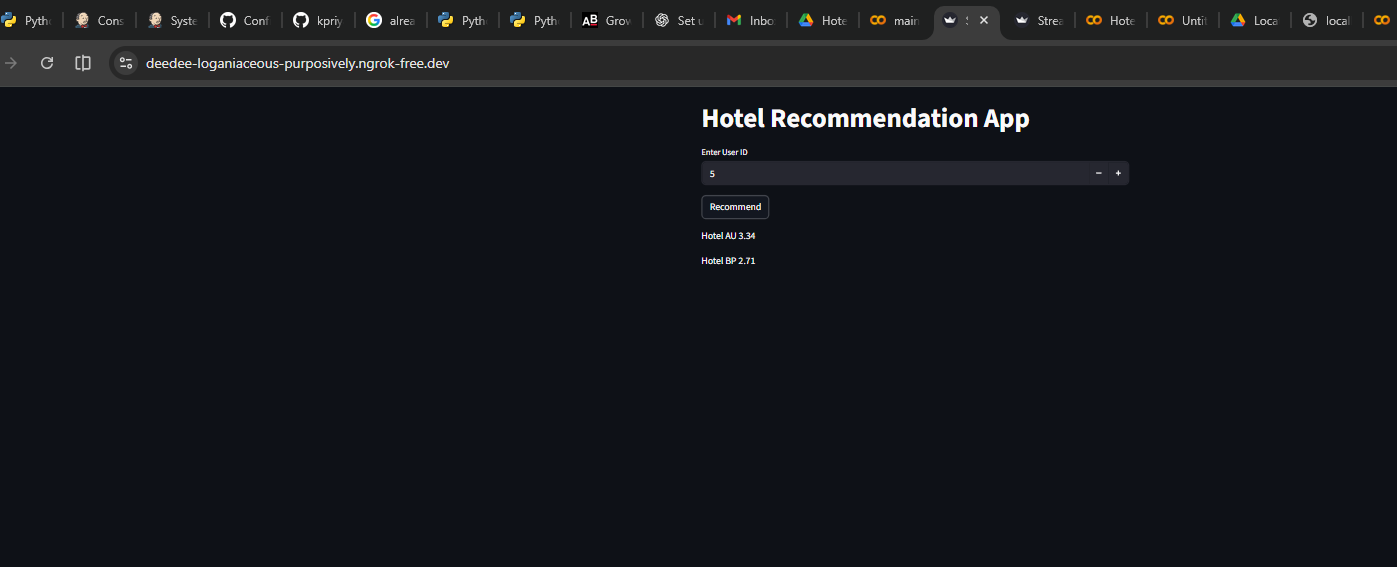

**Project Summary**
The project began with data cleaning and exploratory data analysis (EDA) to understand booking patterns, handle missing values, remove duplicates, and prepare the dataset for modeling. A normalized rating scale was created from the total booking cost to represent user preferences.

To generate personalized recommendations, two approaches were implemented. First, a collaborative filtering model was built using matrix factorization techniques to learn user–hotel interaction patterns from historical booking data. Second, a content-based filtering method was developed by analyzing hotel attributes like name and location using text vectorization and similarity measures.

These two approaches were combined into a hybrid recommendation system, which improves accuracy by leveraging both user behavior and hotel similarity. This helps address challenges such as data sparsity and cold-start problems.

To make the system user-friendly, an interactive Streamlit web application was developed, allowing users to enter their ID and receive real-time hotel recommendations. The application was deployed using a cloud tunneling service for public access and demonstration.

Overall, this project demonstrates an end-to-end machine learning pipeline, including data preprocessing, feature engineering, model development, hybrid recommendation design, and web app deployment, delivering accurate and personalized hotel suggestions.

#